# Producing the Transfer Functions

In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

## Notebook Initialization

In [3]:
%autoreload
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
import darkhistory.physics as phys
import darkhistory.utilities as utils

from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

# np.set_printoptions(threshold=np.nan)

## Import Raw Data

In [4]:
# For complete_coarse
xes_str = [
    '4.540E-05', '2.746E-04', '1.659E-03', '9.952E-03', '5.732E-02',
    '2.689E-01', '6.900E-01', '9.309E-01', '9.879E-01', '9.980E-01',
    '9.997E-01'   
]

file_names = [
    '/Users/hongwan/Dropbox (MIT)/Photon Deposition/'
    +'full_transferfunctions_coarse/'
    +'transferfunction_withloweng_cmbloss_60eV_fixed_binning_complete_coarse_xe_'
    +str+'_nointerp.p'
    for str in xes_str    
]

raw_tf_tuple = [pickle.load(open(file_name, "rb")) for file_name in file_names]

# xe, in_eng, rs, eng, type={highengphot, lowengphot, lowengelec}
raw_tf_list = np.array([tup[0] for tup in raw_tf_tuple])
# Truncate the energy binning, because in_eng does not go up to the end.
raw_tf_list = raw_tf_list[:,:,:,:494,:]
# xe, in_eng, rs
CMB_engloss_list = np.array([tup[1] for tup in raw_tf_tuple])
# xe, in_eng, rs, type={mwimp, rs}
info_list = np.array([tup[2] for tup in raw_tf_tuple])
# xe, in_eng, rs, type={photeng, eleceng}, eng
abscissae_list = np.array([tup[3] for tup in raw_tf_tuple])
abscissae_list = abscissae_list[:,:,:,:,:494]



In [5]:
# This checks that all of the abscissae are equal.
for i in np.arange(info_list.shape[0]):
    for j in np.arange(info_list.shape[1]):
        if not np.array_equal(
            info_list[i,j,:,1],
            info_list[0,0,:,1]
        ):
            print('NOPE!')
        for k in np.arange(info_list.shape[2]):
            if not np.array_equal(
                info_list[i,:,k,0],
                info_list[0,:,0,0]
            ):
                print('NOPE!')
            if not np.array_equal(
                abscissae_list[i,j,k,0,:],
                abscissae_list[0,0,0,0,:]
            ):
                print('NOPE!')
            if not np.array_equal(
                abscissae_list[i,j,k,1,:],
                abscissae_list[0,0,0,1,:]
            ):
                print('NOPE!')
                
# Given that they are, let's just define photeng and eleceng. 
xe_arr = 0.5 + 0.5*np.tanh(
    np.array(
        [-5., -4.1, -3.2, -2.3, -1.4, 
        -0.5, 0.4, 1.3, 2.2, 3.1, 4.]
    )
)
rs_arr    = info_list[0,0,:,1]
mwimp_arr = info_list[0,:,0,0]
photeng = abscissae_list[0,0,0,0,:]
eleceng = abscissae_list[0,0,0,1,:]

In [30]:
#### SANDBOX, DELETE WHEN DONE ####

i_rs = 15
i_in_eng = 14

#xe, in_eng, rs
CMBloss = CMB_engloss_list[0, i_in_eng, i_rs]

# xe, in_eng, rs, eng, type={highengphot, lowengphot, lowengelec}
spec = raw_tf_list[0,i_in_eng, i_rs, :, 1]


dt = 0.001/phys.hubble(rs_arr[i_rs])
print(phys.hubble(rs_arr[i_rs]))
dlne = np.log(photeng[1]) - np.log(photeng[0])

print(rs_arr[i_rs])
print(np.log10(mwimp_arr[i_in_eng]))
print(CMBloss*dt)
print(np.dot(spec, photeng**2)*dlne)

1.9344335480216649e-16
29.14596136854208
4.79482815226887
7.29337563778842
3.8003655265105674


## Raw Data Manipulation

The transfer function is calculated by injecting 2 photons at the input energy abscissa. However, the first step is to assign $x$ photons to the top bin of the *output* photon abscissa, such that $x$ times the energy of the top bin is 2 times the injection energy. Because of the misalignment between the two abscissae, as well as the fact that we want to transfer function for a single electron, we have to normalize the results first.

First, we construct two arrays: a list of output abscissae (for both photons and electrons) given the injection abscissa, and a list of the energy of the *output* photon energy bin where the injected photons are assigned to. Then we compute the normalization factor. 

In [140]:
photeng_bin_width = np.diff(spectools.get_bin_bound(photeng))
eleceng_bin_width = np.diff(spectools.get_bin_bound(eleceng))
# Original injection energies
top_photeng_bins = np.array(
    [
        photeng[photeng <= mwimp][-1]
        for mwimp in mwimp_arr
    ]
)

norm_fac_arr = 2*mwimp_arr/top_photeng_bins

In [141]:
utils.compare_arr([mwimp_arr, top_photeng_bins, norm_fac_arr])
utils.compare_arr([photeng, eleceng])

[[6.10000000e+01 5.98702564e+01 2.03773973e+00]
 [9.85435428e+01 9.50949801e+01 2.07252881e+00]
 [1.61847164e+02 1.51044204e+02 2.14304368e+00]
 [2.65816549e+02 2.59144275e+02 2.05149467e+00]
 [4.36575074e+02 4.11612061e+02 2.12129389e+00]
 [7.17027576e+02 7.06196636e+02 2.03067400e+00]
 [1.17764063e+03 1.12168812e+03 2.09976483e+00]
 [1.93414799e+03 1.92446347e+03 2.01006465e+00]
 [3.17662993e+03 3.05672342e+03 2.07845427e+00]
 [5.21727279e+03 4.85514962e+03 2.14917075e+00]
 [8.56880907e+03 8.32990735e+03 2.05735999e+00]
 [1.40733467e+04 1.32308165e+04 2.12735877e+00]
 [2.31139574e+04 2.26999132e+04 2.03647980e+00]
 [3.79621876e+04 3.60554293e+04 2.10576816e+00]
 [6.23488076e+04 6.18597590e+04 2.01581153e+00]
 [1.02401207e+05 9.82550085e+04 2.08439668e+00]
 [1.68182961e+05 1.56063438e+05 2.15531534e+00]
 [2.76222414e+05 2.67755699e+05 2.06324209e+00]
 [4.53665589e+05 4.25290026e+05 2.13344100e+00]
 [7.45096906e+05 7.29663715e+05 2.04230220e+00]
 [1.22374148e+06 1.15896207e+06 2.111788

0

Dividing by the normalization factor gives the spectra for the injection of 1 photon, with energy given by `top_photeng_bins`. 

Now we construct a raw array of all of the transfer functions, on which we will perform an interpolation to extract a set of transfer functions for use, given a chosen abscissa.

In [213]:
# Multiplying by bin width converts all the eleceng array into number of particles. 
# Indexing: xe, in_eng, rs, eng, type={highengphot, lowengphot, lowengelec}

phot_tf_raw = np.array([
    [
        [
            raw_tf[i,j,:,0]/norm_fac*photeng_bin_width
                for (j, rs) in enumerate(rs_arr)   
        ]
        for (i, (in_eng, norm_fac)) in enumerate(zip(mwimp_arr, norm_fac_arr))
        
    ] for raw_tf in tqdm(raw_tf_list)
])

lowengphot_tf_raw = np.array([
    [
        [
            raw_tf[i,j,:,1]/norm_fac*photeng_bin_width 
                for (j, rs) in enumerate(rs_arr)   
        ]
        for (i, (in_eng, norm_fac)) in enumerate(zip(mwimp_arr, norm_fac_arr))
        
    ] for raw_tf in tqdm(raw_tf_list)
])

lowengelec_tf_raw = np.array([
    [
        [
            raw_tf[i,j,:,2]/norm_fac*eleceng_bin_width 
                for (j, rs) in enumerate(rs_arr)   
        ]
        for (i, (in_eng, norm_fac)) in enumerate(zip(mwimp_arr, norm_fac_arr))
        
    ] for raw_tf in tqdm(raw_tf_list)
])

# xe, in_eng, rs
CMB_engloss = CMB_engloss_list/np.outer(norm_fac_arr, np.ones_like(rs_arr))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

## Some Plots to Check

In [214]:
phot_tf_raw.shape

(11, 51, 51, 494)

3375088672899.8916
3371688622964.796


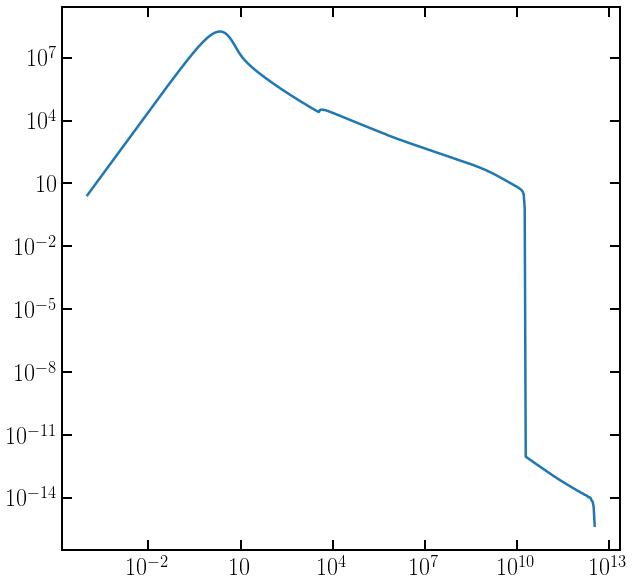

In [215]:
plt.figure()

injE_ind = 50

#xe, in_eng, rs, eng
plt.plot(photeng, phot_tf_raw[-1, injE_ind , -1, :])

ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

# These two should be similar: 
# It is the file total energy in the high energy photon spectrum
# compared to the injection energy. 
print(np.dot(photeng, phot_tf_raw[-1, injE_ind, -1, :]))
print(top_photeng_bins[injE_ind])

In [216]:
# indices where the old injection energy binning lies above/below 3keV.
ind_top_photeng_above_3keV = np.where(top_photeng_bins > 3000)[0][0]

Now we build the transfer functions, given some initial abscissa that will be used throughout the code. The right thing to do is simply to interpolate directly over the raw arrays above, as a function of the injection energy. 

In [217]:
a = phot_tf_raw*photeng
a.shape

(11, 51, 51, 494)

In [218]:
#####################################
# 2D Interpolation Method           #
#####################################

photeng_low  = photeng[photeng <= 60]
photeng_high = photeng[photeng > 60]

# Index where the new injection energy lies above 3keV.
ind_photeng_high_above_3keV = np.where(photeng_high > 3000)[0][0]

print('Creating high energy photon transfer function interpolation table...')

phot_tf_raw_eng = phot_tf_raw*photeng

if phot_tf_raw_eng.shape[0] == xe_arr.size:
    phot_tf_raw_eng = np.transpose(phot_tf_raw_eng, axes=(1, 3, 2, 0))
# At this point, phot_tf has dimensions (in_eng, eng, rs, xe)

new_phot_tf_raw_eng_interp = RegularGridInterpolator(
    (np.log(top_photeng_bins), np.log(photeng)), phot_tf_raw_eng
)

if phot_tf_raw_eng.shape[-1] == xe_arr.size:
    # back to xe, in_eng, rs, out_eng
    phot_tf_raw_eng = np.transpose(phot_tf_raw_eng, (3, 0, 2, 1))

print('Creating low energy photon transfer function interpolation table...')

# xe, in_eng, rs, out_eng for lowengphot_tf_raw
new_lowengphot_below_3keV_tf_raw_interp = interp1d(
    np.log(top_photeng_bins[:ind_top_photeng_above_3keV]),
    lowengphot_tf_raw[:, :ind_top_photeng_above_3keV, :, :],
    bounds_error = False, 
    fill_value = (np.nan, lowengphot_tf_raw[:, ind_top_photeng_above_3keV-1, :, :]),
    axis=1
)

new_lowengphot_above_3keV_tf_raw_interp = interp1d(
    np.log(top_photeng_bins[ind_top_photeng_above_3keV:]), 
    lowengphot_tf_raw[:, ind_top_photeng_above_3keV:, :, :],
    bounds_error = False, 
    fill_value = (lowengphot_tf_raw[:, ind_top_photeng_above_3keV, :, :], np.nan),
    axis=1
)

# The interpolation is split because of the sudden transition between photoionizers below 3keV
# (immediately gets output) vs. photoionizers above 3keV (produces electrons first)

print('Creating low energy electron transfer function interpolation table...')
new_lowengelec_below_3keV_tf_raw_interp = interp1d(
    np.log(top_photeng_bins[:ind_top_photeng_above_3keV]), 
    lowengelec_tf_raw[:,:ind_top_photeng_above_3keV,:,:], 
    bounds_error = False, 
    fill_value = (np.nan, lowengelec_tf_raw[:,ind_top_photeng_above_3keV-1,:,:]),
    axis=1
)

new_lowengelec_above_3keV_tf_raw_interp = interp1d(
    np.log(top_photeng_bins[ind_top_photeng_above_3keV:]), 
    lowengelec_tf_raw[:,ind_top_photeng_above_3keV:,:,:], 
    bounds_error = False, 
    fill_value = (lowengelec_tf_raw[:,ind_top_photeng_above_3keV,:,:], np.nan),
    axis=1
)

print('Creating CMB loss table...')
# xe, in_eng, rs
new_cmbloss_interp = interp1d(np.log(top_photeng_bins), CMB_engloss, axis=1)
print('Interpolation tables created!')

paired_coords = np.array(
    [[i,j] for i in np.log(photeng_high) for j in np.log(photeng)]
)

print('Interpolating high energy photon transfer functions...')
new_phot_tf_raw = new_phot_tf_raw_eng_interp(paired_coords)

new_phot_tf_raw = np.reshape(new_phot_tf_raw, (photeng_high.size, photeng.size, rs_arr.size, xe_arr.size))

if new_phot_tf_raw.shape[-1] == xe_arr.size:
    # back to xe, in_eng, rs, out_eng
    new_phot_tf_raw = np.transpose(new_phot_tf_raw, (3, 0, 2, 1))

new_phot_tf_raw = new_phot_tf_raw/photeng

print('Interpolating low energy photon transfer functions...')
new_lowengphot_below_3keV_tf_raw = new_lowengphot_below_3keV_tf_raw_interp(
    np.log(photeng_high[:ind_photeng_high_above_3keV])
)

new_lowengphot_above_3keV_tf_raw = new_lowengphot_above_3keV_tf_raw_interp(
    np.log(photeng_high[ind_photeng_high_above_3keV:]*(1-1e-12))
)



print('Interpolating low energy electron transfer functions...')
new_lowengelec_below_3keV_tf_raw = new_lowengelec_below_3keV_tf_raw_interp(
    np.log(photeng_high[:ind_photeng_high_above_3keV])
)
new_lowengelec_above_3keV_tf_raw = new_lowengelec_above_3keV_tf_raw_interp(
    np.log(photeng_high[ind_photeng_high_above_3keV:]*(1-1e-12))
)

print('Concatenating the low energy interpolation results...')
new_lowengphot_tf_raw = np.concatenate([new_lowengphot_below_3keV_tf_raw, new_lowengphot_above_3keV_tf_raw], axis=1)
new_lowengelec_tf_raw = np.concatenate([new_lowengelec_below_3keV_tf_raw, new_lowengelec_above_3keV_tf_raw], axis=1)

print('Interpolating CMB loss table...')
new_cmbloss_raw = new_cmbloss_interp(np.log(photeng_high))
print('Interpolation complete!')

Creating high energy photon transfer function interpolation table...
Creating low energy photon transfer function interpolation table...
Creating low energy electron transfer function interpolation table...
Creating CMB loss table...
Interpolation tables created!
Interpolating high energy photon transfer functions...
Interpolating low energy photon transfer functions...
Interpolating low energy electron transfer functions...
Concatenating the low energy interpolation results...
Interpolating CMB loss table...
Interpolation complete!


Original code, injection energy:  24233626378.36927
Original code, total N:  70576537.01013355
Original code, total N, one index down:  1411785.9608780365
Original code, total energy in highengphot:  24309469870.25094
Interpolated, injection energy:  1509174872.8841581
Interpolated, total N:  755239.0488629707
Interpolated, total energy in highengphot:  1563052483.1690688
Ratio of energies:  0.9655305174553868


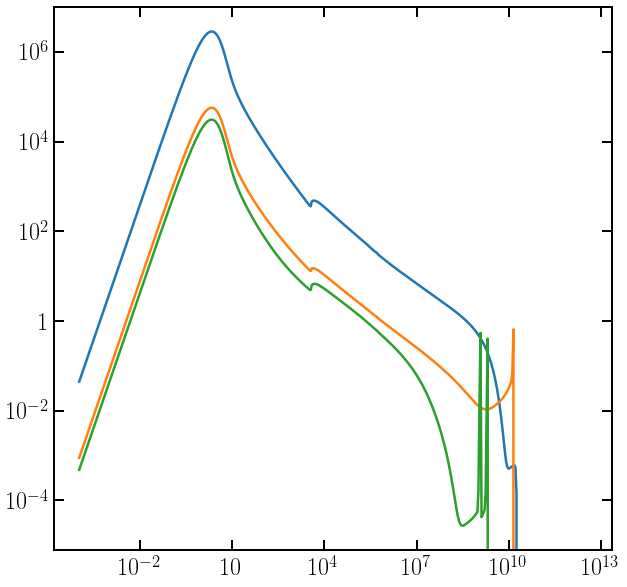

In [246]:
plt.figure()

injE_ind_orig = 40
injE_ind_new = 220


#xe, in_eng, rs, eng
plt.plot(photeng, phot_tf_raw[-1, injE_ind_orig , -1, :])
plt.plot(photeng, phot_tf_raw[-1, injE_ind_orig-1 , -1, :])
plt.plot(photeng, new_phot_tf_raw[-1, injE_ind_new, -1, :])

ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

# These two should be similar: 
# It is the file total energy in the high energy photon spectrum
# compared to the injection energy. 

print('Original code, injection energy: ', top_photeng_bins[injE_ind_orig])

print('Original code, total N: ', np.sum(phot_tf_raw[-1, injE_ind_orig, -1, :]))
print('Original code, total N, one index down: ', np.sum(phot_tf_raw[-1, injE_ind_orig-1, -1, :]))

print('Original code, total energy in highengphot: ', np.dot(photeng, phot_tf_raw[-1, injE_ind_orig, -1, :]))

print('Interpolated, injection energy: ', photeng_high[injE_ind_new])

print('Interpolated, total N: ', np.sum(new_phot_tf_raw[-1, injE_ind_new, -1, :]))

print('Interpolated, total energy in highengphot: ', np.dot(photeng, new_phot_tf_raw[-1, injE_ind_new, -1, :]))
print('Ratio of energies: ', photeng_high[injE_ind_new]/np.dot(photeng, new_phot_tf_raw[-1, injE_ind_new, -1, :]))


Now, we construct the list of `Spectrum` objects from our raw array of transfer functions...

In [242]:
# spec_type = 'N' for eleceng, because we have already multiplied in the bin width earlier. 

#xe, in_eng, rs, eng
photspec_list = [
    [
        [
            Spectrum(
                photeng, phot_tf[i,j,:], spec_type='N', 
                rs = rs, in_eng = in_eng
            ) for (j, rs) in enumerate(rs_arr)
        ] for (i, in_eng) in enumerate(photeng_high)
    ] for phot_tf in tqdm(new_phot_tf_raw)
]

lowengphotspec_list = [
    [
        [
            Spectrum(
                photeng, lowengphot_tf[i,j,:], spec_type='N', 
                rs = rs, in_eng = in_eng
            ) for (j, rs) in enumerate(rs_arr)
        ] for (i, in_eng) in enumerate(photeng_high)
    ] for lowengphot_tf in tqdm(new_lowengphot_tf_raw)
]

lowengelecspec_list = [
    [
        [
            Spectrum(
                eleceng, lowengelec_tf[i,j,:], spec_type='N', 
                rs = rs, in_eng = in_eng
            ) for (j, rs) in enumerate(rs_arr)
        ] for (i, in_eng) in enumerate(photeng_high)
    ] for lowengelec_tf in tqdm(new_lowengelec_tf_raw)
]


HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

Finally, we can construct the `TransferFuncList` from this.

In [243]:
tfunclist_photspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.002)
            for spec_arr in photspec_xe
        ]
    ) for photspec_xe in tqdm(photspec_list)
]

tfunclist_lowengphotspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.002)
            for spec_arr in lowengphotspec_xe
        ]
    ) for lowengphotspec_xe in tqdm(lowengphotspec_list)
]
    

tfunclist_lowengelecspec_list = [
    tflist.TransferFuncList(
        [
            tf.TransFuncAtEnergy(spec_arr, dlnz=0.002)
            for spec_arr in lowengelecspec_xe
        ]
    ) for lowengelecspec_xe in tqdm(lowengelecspec_list)
]

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

We will now transpose all of the `TransferFuncList` objects so that they are now all of type `'rs'`.

In [244]:
for tflist_hep, tflist_lep, tflist_lee in zip(
    tfunclist_photspec_list, tfunclist_lowengphotspec_list, tfunclist_lowengelecspec_list):
    tflist_hep.transpose()
    tflist_lep.transpose()
    tflist_lee.transpose()
    for i, tf_hep, tf_lep, tf_lee in zip(np.arange(327), tflist_hep, tflist_lep, tflist_lee):
        if np.any(np.isnan(tf_hep._grid_vals)):
            print(np.where(np.isnan(tf_hep._grid_vals)),'here!')
        if np.any(np.isnan(tf_lep._grid_vals)):
            print(np.where(np.isnan(tf_lep._grid_vals)),'here1!')
        if np.any(np.isnan(tf_lee._grid_vals)):
            print(np.where(np.isnan(tf_lee._grid_vals)),'here2!')
        
        tf_hep._grid_vals[np.where(tf_hep.grid_vals < 0)] = 1e-100
        tf_lep._grid_vals[np.where(tf_lep.grid_vals < 0)] = 1e-100
        tf_lee._grid_vals[np.where(tf_lee.grid_vals < 0)] = 1e-100

In [248]:
tfunclist_photspec_list[0].rs

array([   4.        ,    4.56626611,    5.21269655,    5.9506399 ,
          6.79305133,    7.75472002,    8.85252881,   10.10575058,
         11.5363866 ,   13.16955279,   15.03392065,   17.1622206 ,
         19.59181658,   22.36536203,   25.53154867,   29.14596137,
         33.27205392,   37.98226307,   43.35928017,   49.49750292,
         56.50469254,   64.50386567,   73.63545397,   84.05976951,
         95.95981921,  109.54451763,  125.05235464,  142.75558229,
        162.9649944 ,  186.03538282,  212.37176602,  242.43649955,
        276.75739302,  315.93697621,  360.66307695,  411.72089648,
        470.00679424,  536.54402417,  612.50069871,  699.21029593,
        798.19506977,  911.19277434, 1040.18717161, 1187.44285781,
       1355.54502022, 1547.44482208, 1766.51121258, 2016.59007136,
       2302.07172587, 2627.96802697, 3000.00033585])

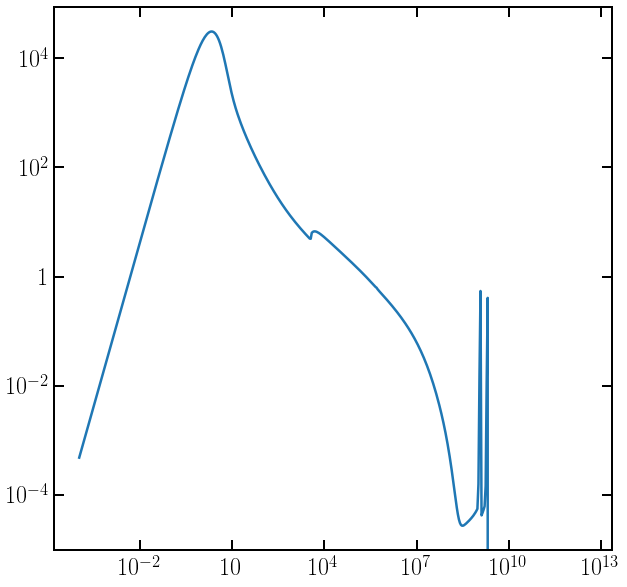

In [250]:
test = tfunclist_photspec_list[-1][-1]
# print(test.rs)

plt.figure()

ax = plt.gca()

test.plot(ax, ind=220, indtype='ind')

# test.plot(ax, ind=(0,327), step=2)
# test.plot(ax, ind=(48, 51), step=1)

ax.set_xscale('log')
ax.set_yscale('log')

In [251]:
ind = 220
# print(test.in_eng)
print(test.in_eng[ind])
print(np.log10(test.in_eng[ind]))
print(np.dot(test[ind].N,test[ind].eng))
print(test[ind].toteng())
print(test.in_eng[ind]/test[ind].toteng())

1509174872.8841581
9.178739565771867
1563052483.1690693
1563052483.1690693
0.9655305174553864


[0.0001, 5000000000000.0, 1e-42, 300.0]

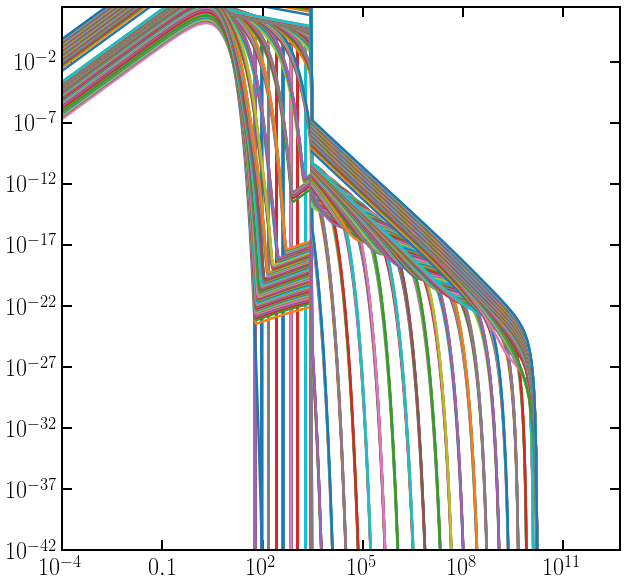

In [252]:
test = tfunclist_lowengphotspec_list[-1][-1]

plt.figure()

ax = plt.gca()

test.plot(ax, step=5)

ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-4, 5e12, 1e-42, 3e2])

[0.1, 4000.0, 1e-12, 100.0]

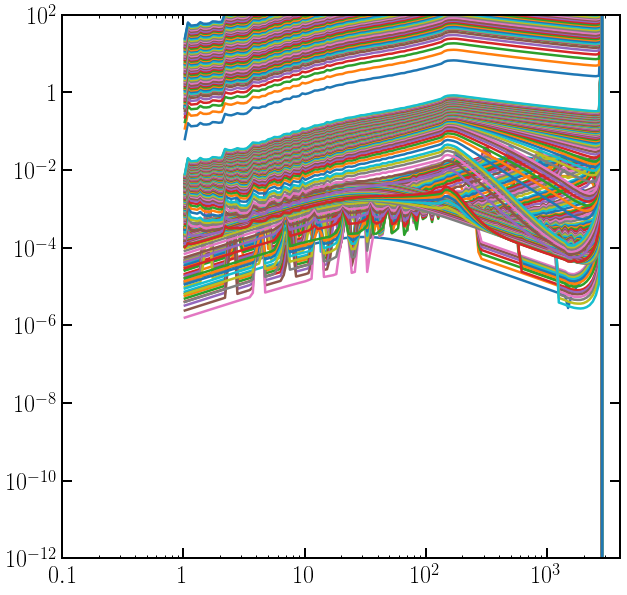

In [253]:
test = tfunclist_lowengelecspec_list[-1][-1]

plt.figure()

ax = plt.gca()

test.plot(ax,step=5)

# test.plot(ax, ind=(0, 326), step=1)
# test.plot(ax, ind=np.array([50]))
ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e-1, 4e3, 1e-12, 1e2])

In [27]:
tfunclist_lowengelecspec_list[-1][0].in_eng[76]

21166.77319300623

Save the transfer functions.

In [254]:
# for complete_coarse

pickle.dump(tfunclist_photspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "wb")
           )

pickle.dump(tfunclist_lowengphotspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "wb")
           )

pickle.dump(tfunclist_lowengelecspec_list, 
           open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "wb")
           )

pickle.dump(
    new_cmbloss_raw, 
    open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "wb")       
           )

########################################################
########################################################

# for z=31 test one xe.

# pickle.dump(tfunclist_photspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_list_new_fixed_binning.raw", "wb")
#            )

# pickle.dump(tfunclist_lowengphotspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_list_new_fixed_binning.raw", "wb")
#            )

# pickle.dump(tfunclist_lowengelecspec_list, 
#            open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_list_new_fixed_binning.raw", "wb")
#            )

# pickle.dump(
#     new_cmbloss_raw, 
#     open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_list_new_fixed_binning.raw", "wb")       
#            )